0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [27]:
#Loaidng basic dependencies

import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



print(os.listdir("../input"))

['maintraintest', 'review', 'sentiment-analysis-on-movie-reviews', 'demo-3']


In [28]:
#importing the NLP Libraries
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [29]:
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from keras.optimizers import Adam
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.losses import categorical_crossentropy
from keras.models import Sequential
set_random_seed(123)

In [30]:
random.seed(123)

In [31]:
#loading the datatset for baseline model
train= pd.read_csv(r"../input/maintraintest/train.tsv", sep="\t")
test = pd.read_csv(r"../input/maintraintest/test.tsv", sep="\t")
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [32]:
print(train.shape)
print(test.shape)

(156060, 4)
(66292, 3)


In [33]:
test.head(5)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [34]:
#cleaning the review and this usually includes
#remove html content
#remove non-alphabetic characters
#tokenize the sentences
#lemmatize each word to its lemma


def clean_sentences(df):
    reviews = []
    for sent in tqdm(df['Phrase']):
        review_text = BeautifulSoup(sent).get_text()
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        words = word_tokenize(review_text.lower())
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)
    return(reviews)

# Concise text with after getting cleaned
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

100%|██████████| 66292/66292 [00:34<00:00, 1943.87it/s]


In [35]:
print(len(train_sentences))
print(len(test_sentences))

156060
66292


In [36]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [37]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

## Geting the no of unique words and max length of a review available in the list of cleaned reviews.

In [38]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 448927.40it/s]

13736
48


In [39]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [40]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]



In [41]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4120800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 4,396,861
Trainable params: 4,396,861
Non-trainable params: 0
_________________________________________________________________


## fit the model

In [42]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=15, batch_size=256, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/15
124848/124848 [==============================] - 89s 712us/step - loss: 1.0082 - acc: 0.5965 - val_loss: 0.8459 - val_acc: 0.6547
Epoch 2/15
124848/124848 [==============================] - 87s 693us/step - loss: 0.8070 - acc: 0.6686 - val_loss: 0.8251 - val_acc: 0.6656
Epoch 3/15
124848/124848 [==============================] - 87s 697us/step - loss: 0.7386 - acc: 0.6917 - val_loss: 0.8198 - val_acc: 0.6677
Epoch 4/15
124848/124848 [==============================] - 87s 699us/step - loss: 0.6977 - acc: 0.7069 - val_loss: 0.8391 - val_acc: 0.6712
Epoch 5/15
124848/124848 [==============================] - 86s 690us/step - loss: 0.6695 - acc: 0.7187 - val_loss: 0.8712 - val_acc: 0.6705
Epoch 6/15
124848/124848 [==============================] - 86s 692us/step - loss: 0.6559 - acc: 0.7251 - val_loss: 0.8843 - val_acc: 0.6695
Epoch 7/15
124848/124848 [==============================] - 87s 698us/step - loss: 0.6427 - acc: 0.7298

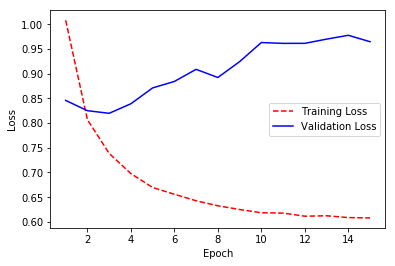

In [43]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
from keras.models import load_model
model.save("my_model_with_5_sentiments.h5")

In [45]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_val)



In [46]:
crikiter_data=pd.read_csv(r"../input/review/movie_review.tsv",sep="\t")

In [47]:
crikiter_data.head(10)

,Movie,Review
0,Groundhog Day,You will not be permitted to continue your lif...
1,Pulp Fiction,(after repeat viewings) Among my favourite scr...
2,Apocalypse Now,"My favorite film, a surreal, haunting, visuall..."
3,Lost in Translation,I love it. It's just nice to look at all the ...
4,Let the Right One In,Truly original. Perfectly balanced. The mix of...
5,Jack,Francis Ford Coppola's masterful followup to T...
6,Terminator 2: Judgment Day,This movie is the true reason for Arnold Schwa...
7,Jurassic World,..and as you can see the head accountant conti...
8,Chinatown,"Polanski does a wonderful job, the cast does a..."
9,Alice in Wonderland,In his most strident political commentary sinc...


In [48]:
from sklearn.metrics import accuracy_score

In [49]:
y_classes = [np.argmax(y, axis=None, out=None) for y in y_val]

In [50]:
accuracy=accuracy_score(y_pred,y_classes)
print(accuracy)

0.6665705497885429


In [52]:
from sklearn.metrics import classification_report

target_names = ['class negative', 'class somewhat negative', 'class neutral', 'class somewhat positive', 'class positive']
print(classification_report(y_classes, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

         class negative       0.55      0.30      0.39      1414
class somewhat negative       0.55      0.59      0.57      5455
          class neutral       0.75      0.80      0.77     15916
class somewhat positive       0.59      0.55      0.57      6586
         class positive       0.55      0.44      0.49      1841

               accuracy                           0.67     31212
              macro avg       0.60      0.54      0.56     31212
           weighted avg       0.66      0.67      0.66     31212



In [54]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 300)           4120800   
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 4,396,861
Trainable params: 4,396,861
Non-trainable params: 0
_________________________________________________________________


In [55]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=15, batch_size=256, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/15
124848/124848 [==============================] - 90s 721us/step - loss: 1.1222 - acc: 0.5561 - val_loss: 0.9044 - val_acc: 0.6309
Epoch 2/15
124848/124848 [==============================] - 87s 699us/step - loss: 0.8623 - acc: 0.6529 - val_loss: 0.8355 - val_acc: 0.6601
Epoch 3/15
124848/124848 [==============================] - 88s 704us/step - loss: 0.7925 - acc: 0.6779 - val_loss: 0.8155 - val_acc: 0.6684
Epoch 4/15
124848/124848 [==============================] - 87s 697us/step - loss: 0.7503 - acc: 0.6923 - val_loss: 0.8156 - val_acc: 0.6696
Epoch 5/15
124848/124848 [==============================] - 87s 693us/step - loss: 0.7195 - acc: 0.7033 - val_loss: 0.8102 - val_acc: 0.6705
Epoch 6/15
124848/124848 [==============================] - 88s 703us/step - loss: 0.6932 - acc: 0.7116 - val_loss: 0.8205 - val_acc: 0.6734
Epoch 7/15
124848/124848 [==============================] - 87s 695us/step - loss: 0.6710 - acc: 0.7199

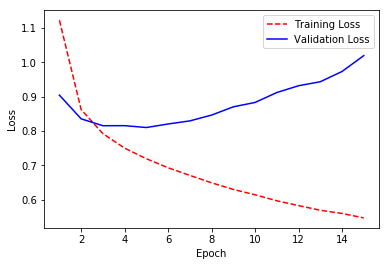

In [56]:
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [57]:
y_pred=model.predict_classes(X_val)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
target_names = ['class negative', 'class somewhat negative', 'class neutral', 'class somewhat positive', 'class positive']
print(classification_report(y_classes, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

         class negative       0.52      0.39      0.44      1414
class somewhat negative       0.55      0.59      0.57      5455
          class neutral       0.76      0.79      0.77     15916
class somewhat positive       0.59      0.59      0.59      6586
         class positive       0.57      0.41      0.48      1841

               accuracy                           0.67     31212
              macro avg       0.60      0.55      0.57     31212
           weighted avg       0.67      0.67      0.67     31212



In [58]:
Y_criticker=crikiter_data.iloc[:,1]

In [59]:
def clean_sentences(df):
    reviews = []
    for sent in tqdm(df):
        #review_text = BeautifulSoup(sent).get_text()
        review_text=str(sent)
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        words = word_tokenize(review_text.lower())
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)
    return(reviews)
Y_crit_clean = clean_sentences(Y_criticker)

100%|██████████| 7491/7491 [00:04<00:00, 1707.64it/s]


In [60]:
print(len(Y_crit_clean))

7491


In [61]:
Y_crit_clean = tokenizer.texts_to_sequences(Y_crit_clean)
Y_sentiment = sequence.pad_sequences(Y_crit_clean, maxlen=len_max)

In [62]:
Sentiment_crit=model.predict_classes(Y_sentiment)


In [63]:
crikiter_data['Predicted']= Sentiment_crit

In [64]:
crikiter_data.to_csv("new_predicted_sentiment_criticker.tsv", sep='\t', encoding='utf-8')

## using three polarity 

In [65]:
train= pd.read_csv(r"../input/maintraintest/train.tsv", sep="\t")      #for training  on the new data please replace address with new_train.csv
test= pd.read_csv(r"../input/maintraintest/test.tsv", sep="\t")


In [66]:
print(train.shape)
print(test.shape)

(156060, 4)
(66292, 3)


In [67]:
train['Sentiment']=train['Sentiment'].replace(to_replace =[0,1],  
                            value =0) 

In [68]:
train['Sentiment']=train['Sentiment'].replace(to_replace =[2],  
                            value =1) 

In [69]:
train['Sentiment']=train['Sentiment'].replace(to_replace =[3,4],  
                            value =2) 

In [70]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
1,2,1,A series of escapades demonstrating the adage ...,1
2,3,1,A series,1
3,4,1,A,1
4,5,1,series,1
5,6,1,of escapades demonstrating the adage that what...,1
6,7,1,of,1
7,8,1,escapades demonstrating the adage that what is...,1
8,9,1,escapades,1
9,10,1,demonstrating the adage that what is good for ...,1


In [71]:
train.to_csv("new_train.csv")

In [72]:
def clean_sentences(df):
    reviews = []
    for sent in tqdm(df['Phrase']):
        review_text = BeautifulSoup(sent).get_text()
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        words = word_tokenize(review_text.lower())
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)
    return(reviews)
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

100%|██████████| 66292/66292 [00:35<00:00, 1883.99it/s]


In [73]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [74]:
y_target

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [75]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [76]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 462401.26it/s]

13737
48


In [77]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [78]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:
num_classes=3
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 300)           4121100   
_________________________________________________________________
lstm_7 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 4,396,959
Trainable params: 4,396,959
Non-trainable params: 0
_________________________________________________________________


In [79]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=15, batch_size=256, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/15
124848/124848 [==============================] - 89s 716us/step - loss: 0.7537 - acc: 0.6838 - val_loss: 0.6351 - val_acc: 0.7404
Epoch 2/15
124848/124848 [==============================] - 86s 686us/step - loss: 0.5921 - acc: 0.7623 - val_loss: 0.6193 - val_acc: 0.7505
Epoch 3/15
124848/124848 [==============================] - 86s 688us/step - loss: 0.5315 - acc: 0.7835 - val_loss: 0.6210 - val_acc: 0.7531
Epoch 4/15
124848/124848 [==============================] - 87s 694us/step - loss: 0.4957 - acc: 0.7956 - val_loss: 0.6448 - val_acc: 0.7535
Epoch 5/15
124848/124848 [==============================] - 86s 688us/step - loss: 0.4681 - acc: 0.8063 - val_loss: 0.6762 - val_acc: 0.7453
Epoch 6/15
124848/124848 [==============================] - 85s 682us/step - loss: 0.4502 - acc: 0.8119 - val_loss: 0.6975 - val_acc: 0.7479
Epoch 7/15
124848/124848 [==============================] - 86s 692us/step - loss: 0.4430 - acc: 0.8145

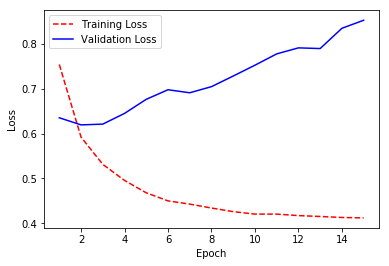

In [80]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [81]:
from keras.models import load_model
model.save("my_model_with_3_sentiments.h5")

In [82]:
crikiter_data=pd.read_csv(r"../input/review/movie_review.tsv",sep="\t")

In [83]:
y_classes = [np.argmax(y, axis=None, out=None) for y in y_val]

In [84]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_val)



In [85]:
from sklearn.metrics import classification_report

target_names = ['class negative', 'class neutral', 'class positive']
print(classification_report(y_classes, y_pred, target_names=target_names))

                precision    recall  f1-score   support

class negative       0.72      0.70      0.71      6869
 class neutral       0.75      0.79      0.77     15916
class positive       0.77      0.71      0.74      8427

      accuracy                           0.75     31212
     macro avg       0.75      0.73      0.74     31212
  weighted avg       0.75      0.75      0.75     31212



In [86]:
Y_criticker=crikiter_data.iloc[:,1]
def clean_sentences(df):
    reviews = []
    for sent in tqdm(df):
        #review_text = BeautifulSoup(sent).get_text()
        review_text=str(sent)
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        words = word_tokenize(review_text.lower())
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)
    return(reviews)
Y_crit_clean = clean_sentences(Y_criticker)
Y_crit_clean = tokenizer.texts_to_sequences(Y_crit_clean)
Y_sentiment = sequence.pad_sequences(Y_crit_clean, maxlen=len_max)
Sentiment_crit=model.predict_classes(Y_sentiment)
crikiter_data['Predicted']= Sentiment_crit


100%|██████████| 7491/7491 [00:04<00:00, 1698.13it/s]


In [87]:
crikiter_data.to_csv("new_predicted_sentiment_criticker_3_sentiments.tsv", sep='\t', encoding='utf-8')

In [88]:
import seaborn as sns

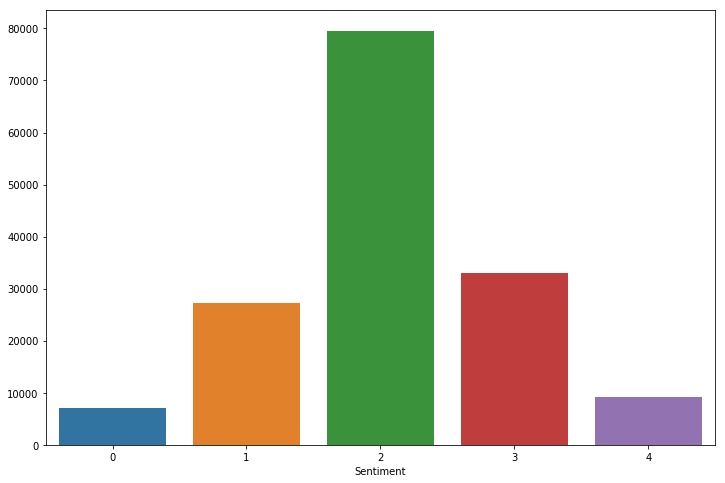

In [89]:
#with 5 polarity class distribution
eda_train= pd.read_csv(r"../input/maintraintest/train.tsv", sep="\t")  
dist = eda_train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);



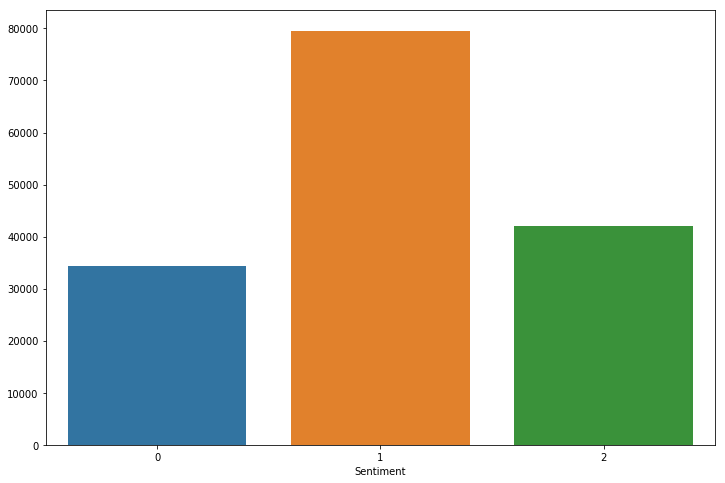

In [90]:
#With 3 polarity class distrbution
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);



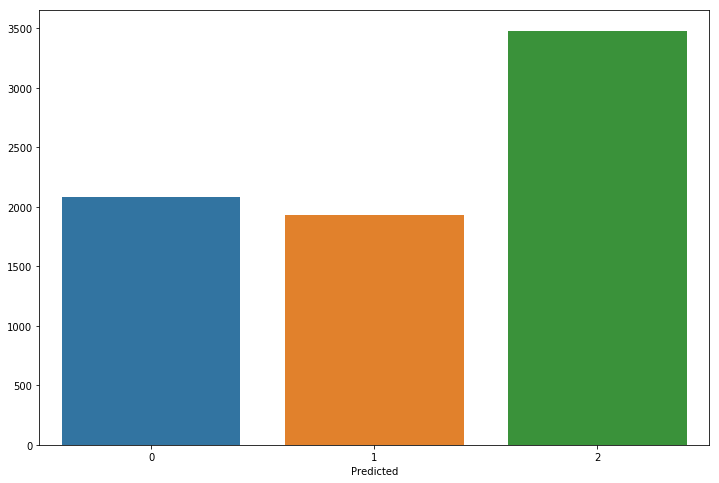

In [91]:
#PREDICTED CLASS FOR OUR SCRAPPED DATA FROM CRITIKER
#with 5 polarity class distribution
dist = crikiter_data.groupby(["Predicted"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);



In [92]:

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

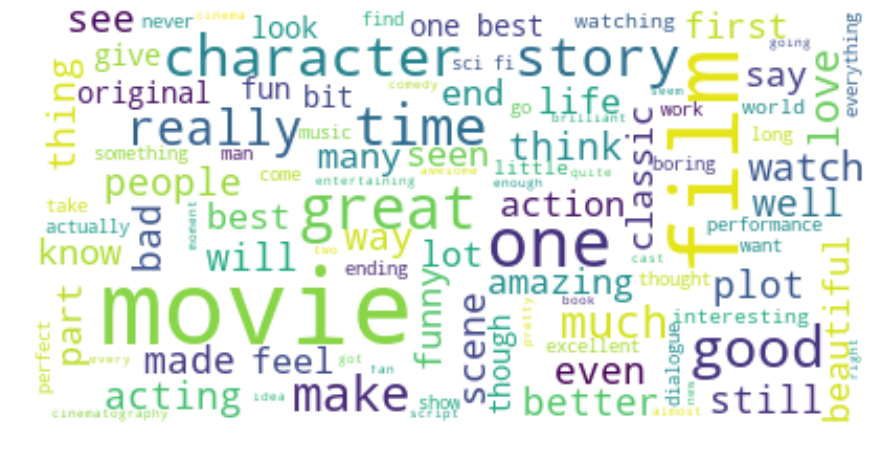

In [114]:
text = "".join(str(review) for review in crikiter_data.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [115]:
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [118]:
all_score2 = nltk.FreqDist(Y_criticker)
all_score_df = pd.DataFrame({'score': list(all_score2.keys()), 
                              'Count': list(all_score2.values())})

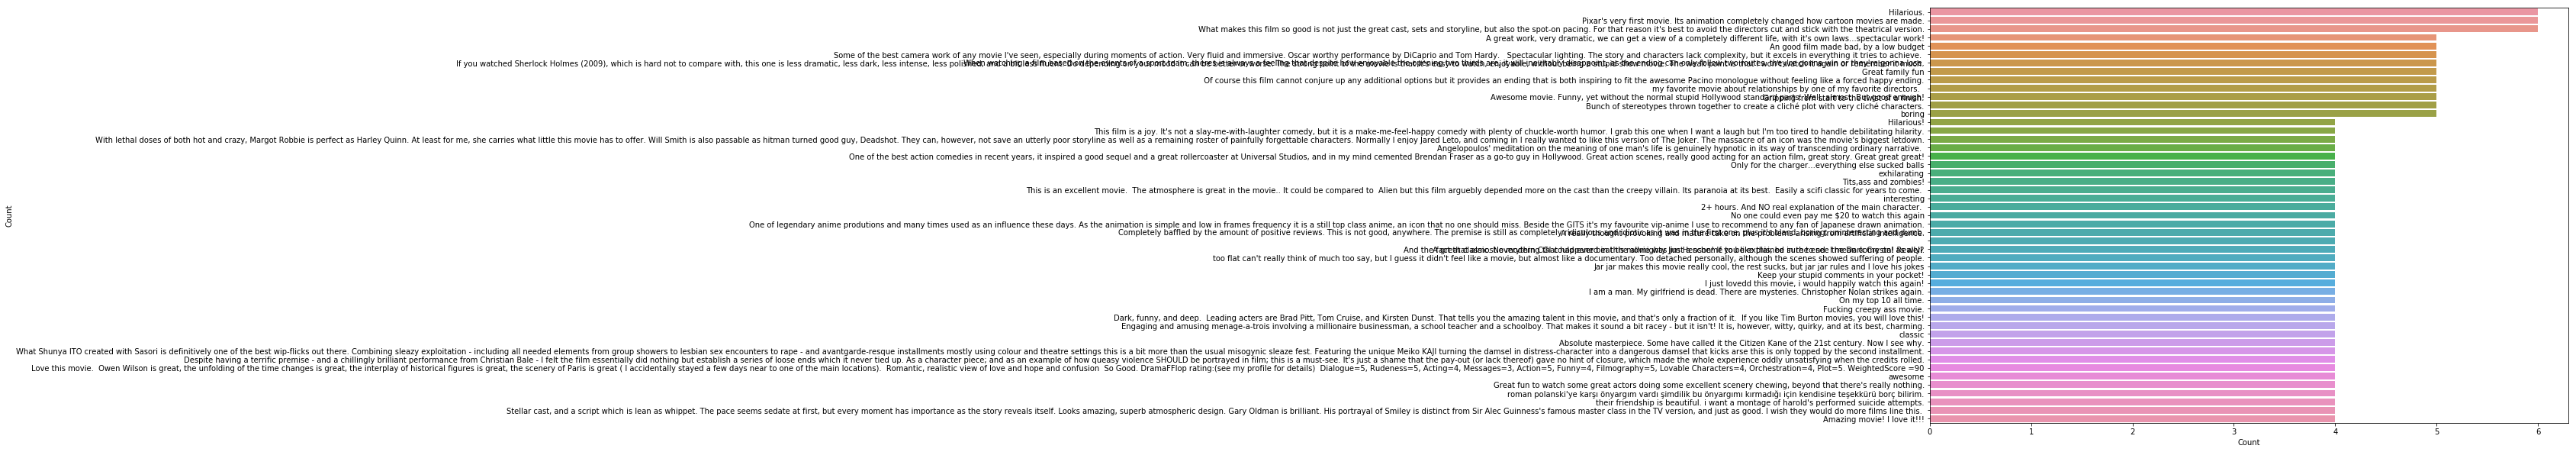

In [120]:
g = all_score_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(15,10)) 
ax = sns.barplot(data=g, x= "Count", y = "score") 
ax.set(ylabel = 'Count') 
plt.show()

In [125]:
def clean_text(text):
    # remove backslash-apostrophe 
    text=str(text)
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [126]:
crikiter_data['Review'] = crikiter_data['Review'].apply(lambda x: clean_text(x))

In [ ]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(crikiter_data['Review'], 100)